<a href="https://colab.research.google.com/github/ashupednekar/StyleEncrypt/blob/master/Style_Encryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from random import randint as ri
from matplotlib import pyplot as plt

In [2]:
# #downloading fonts
# !mkdir fonts
# %cd fonts
# !wget https://noto-website-2.storage.googleapis.com/pkgs/Noto-unhinted.zip
# !unzip Noto-unhinted.zip
# %cd ..
# !cp fonts/NotoSans-Regular.ttf .
# !rm -rf fonts
# !mkdir fonts
# !mv NotoSans-Regular.ttf fonts/

In [3]:
import os
from random import choice

color_mode = 'white' # or random

def create_image_for_text(text, font):
    """Creating content image for a given input"""
    if color_mode == 'random':
        #Creating background with random color
        img = Image.new('RGB', (2048, 512), color = (ri(0,255), ri(0,255), ri(0,255)))
    else:
        #Creating background with random color
        img = Image.new('RGB', (2048, 512), color = (255, 255, 255))
    plt.figure()
    plt.imshow(img)
    fnt = ImageFont.truetype(font, 400)
    d = ImageDraw.Draw(img)
    d.text((0,0), text, font=fnt, fill=(ri(0,255), ri(0,255), ri(0,255)))
    plt.imshow(img)
    img.save('_'.join(text.split(' ')) + '.jpg')
    return '_'.join(text.split(' ')) + '.jpg'

In [4]:
!pip install pycryptodome

In [5]:
"""AES"""
from Crypto.Cipher import AES
from Crypto import Random

key = Random.new().read(AES.block_size)
iv = Random.new().read(AES.block_size)

class ImageEncryptor:

    def encrypt(self, path):
        input_file = open(path, 'rb')
        self.path = path
        input_data = input_file.read()
        input_file.close()
        cfb_cipher = AES.new(key, AES.MODE_CFB, iv)
        enc_data = cfb_cipher.encrypt(input_data)
        return enc_data

    def decrypt(self, enc):
        cfb_decipher = AES.new(key, AES.MODE_CFB, iv)
        plain_data = cfb_decipher.decrypt(enc)
        output_file = open(self.path, "wb")
        output_file.write(plain_data)
        output_file.close()

In [13]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

tf.config.run_functions_eagerly(True)

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

@tf.function()
def train_step(image, loss_function, extractor, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = loss_function(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [7]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [14]:
class StyleTransfer:

    def __init__(self, content_path, style_url=None, style_path=None, steps=100, learning_rate=0.05, beta_1=0.99, epsilon=1e-1):
        self.steps = steps
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.epsilon = epsilon
        self.content_image = self.load_img(content_path)
        if style_path:
            self.style_image = self.load_img(style_path)
        elif style_url:
            self.style_image = self.load_img(self.get_style_image(style_url))
        else:
            return 'No Style Image Provided'
        plt.subplot(1, 2, 1)
        imshow(self.content_image, 'Content Image')
        plt.subplot(1, 2, 2)
        imshow(self.style_image, 'Style Image')
        self.style_layers = ['block1_conv1',
                        'block2_conv1',
                        'block3_conv1', 
                        'block4_conv1', 
                        'block5_conv1']
        self.content_layers = ['block5_conv2'] 
        self.preprocess(self.content_image)
        self.extract()
    
    def get_style_image(self, url):
        os.system('wget '+url)
        os.rename(url.split('/')[-1], 'style.jpg')
        return 'style.jpg'

    def load_img(self, path_to_img):
        max_dim = 512
        img = tf.io.read_file(path_to_img)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)

        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img

    def preprocess(self, content_image):
        x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
        x = tf.image.resize(x, (224, 224))
        vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
        prediction_probabilities = vgg(x)
        prediction_probabilities.shape
        predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
        print([(class_name, prob) for (number, class_name, prob) in predicted_top_5])
        self.num_content_layers = len(self.content_layers)
        self.num_style_layers = len(self.style_layers)

    def extract(self):
        self.style_extractor = vgg_layers(self.style_layers)
        self.style_outputs = self.style_extractor(self.style_image*255)

        #Look at the statistics of each layer's output
        for name, output in zip(self.style_layers, self.style_outputs):
            print(name)
            print("  shape: ", output.numpy().shape)
            print("  min: ", output.numpy().min())
            print("  max: ", output.numpy().max())
            print("  mean: ", output.numpy().mean())
            print()
        
        self.extractor = StyleContentModel(self.style_layers, self.content_layers)
        results = self.extractor(tf.constant(self.content_image))

        print('Styles:')
        for name, output in sorted(results['style'].items()):
            print("  ", name)
            print("    shape: ", output.numpy().shape)
            print("    min: ", output.numpy().min())
            print("    max: ", output.numpy().max())
            print("    mean: ", output.numpy().mean())
            print()

        print("Contents:")
        for name, output in sorted(results['content'].items()):
            print("  ", name)
            print("    shape: ", output.numpy().shape)
            print("    min: ", output.numpy().min())
            print("    max: ", output.numpy().max())
            print("    mean: ", output.numpy().mean())

        self.style_targets = self.extractor(self.style_image)['style']
        self.content_targets = self.extractor(self.content_image)['content']

    def stylize(self):
        image = tf.Variable(self.content_image)
        self.opt = tf.optimizers.Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)
        self.style_weight=1e-2
        self.content_weight=1e4
        from tqdm import tqdm
        for i in tqdm(range(1000)):
            train_step(image, self.add_style_content_loss, self.extractor, self.opt)
        img = tensor_to_image(image)
        plt.figure()
        plt.imshow(img)
        plt.title('Stylized image')
        img.save('stylized.jpg')

    def destylize(self):
        image = tf.Variable(self.content_image)
        self.opt = tf.optimizers.Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, epsilon=seld.epsilon)
        self.style_weight=1e-2
        self.content_weight=1e4
        from tqdm import tqdm
        for i in tqdm(range(self.steps)):
            train_step(image, self.remove_style_content_loss, self.extractor, self.opt)
        img = tensor_to_image(image)
        plt.figure()
        plt.imshow(img)
        plt.title('Stylized image')


    def add_style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) 
                            for name in style_outputs.keys()])
        style_loss *= self.style_weight / self.num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) 
                                for name in content_outputs.keys()])
        content_loss *= self.content_weight / self.num_content_layers
        loss = style_loss + content_loss
        return loss


    def remove_style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) 
                            for name in style_outputs.keys()])
        style_loss *= self.style_weight / self.num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) 
                                for name in content_outputs.keys()])
        content_loss *= self.content_weight / self.num_content_layers
        loss = content_loss - style_loss
        return loss

In [9]:
# !wget https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

/content/fonts/NotoSans-ExtraCondensedItalic.ttf
[('envelope', 0.06923534), ('web_site', 0.057407036), ('screwdriver', 0.02819108), ('nail', 0.026491292), ('swab', 0.024363576)]
block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



  0%|          | 0/1000 [00:00<?, ?it/s]

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  203640.56
    mean:  640.7506

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  321573.06
    mean:  17803.396

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  2540728.5
    mean:  28537.857

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  15303989.0
    mean:  299466.62

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  203038.2
    mean:  1359.512

Contents:
   block5_conv2
    shape:  (1, 8, 32, 512)
    min:  0.0
    max:  1089.9733
    mean:  11.306615


  0%|          | 4/1000 [00:02<10:32,  1.57it/s]

  0%|          | 5/1000 [00:02<09:15,  1.79it/s]

  1%|          | 6/1000 [00:03<08:22,  1.98it/s]

  1%|          | 7/1000 [00:03<08:22,  1.97it/s]

  1%|          | 8/1000 [00:03<07:44,  2.13it/s]

  1%|          | 9/1000 [00:04<07:14,  2.28it/s]

  1%|          | 10/1000 [00:04<06:54,  2.39it/s]

  1%|          | 11/1000 [00:05<06:44,  2.44it/s]

  1%|          | 12/1000 [00:05<06:35,  2.50it/s]

  1%|▏         | 13/1000 [00:05<06:28,  2.54it/s]

  1%|▏         | 14/1000 [00:06<06:25,  2.56it/s]

  2%|▏         | 15/1000 [00:06<06:25,  2.56it/s]

  2%|▏         | 16/1000 [00:06<06:23,  2.57it/s]

  2%|▏         | 17/1000 [00:07<06:23,  2.56it/s]

  2%|▏         | 18/1000 [00:07<06:21,  2.57it/s]

  2%|▏         | 19/1000 [00:08<06:21,  2.57it/s]

  2%|▏         | 20/1000 [00:08<06:19,  2.58it/s]

  2%|▏         | 21/1000 [00:08<06:15,  2.61it/s]

  2%|▏         | 22/1000 [00:09<06:17,  2.59it/s]

  2%|▏         | 23/1000 [00:09<06:50,  2.38it/s]

  2%|▏         | 24/1000 [00:10<06:40,  2.44it/s]

  2%|▎         | 25/1000 [00:10<06:30,  2.50it/s]

  3%|▎         | 26/1000 [00:10<06:21,  2.56it/s]

  3%|▎         | 27/1000 [00:11<06:19,  2.57it/s]

  3%|▎         | 28/1000 [00:11<06:13,  2.60it/s]

  3%|▎         | 29/1000 [00:12<06:18,  2.56it/s]

  3%|▎         | 30/1000 [00:12<06:17,  2.57it/s]

  3%|▎         | 31/1000 [00:12<06:14,  2.59it/s]

  3%|▎         | 32/1000 [00:13<06:14,  2.59it/s]

  3%|▎         | 33/1000 [00:13<06:12,  2.59it/s]

  3%|▎         | 34/1000 [00:13<06:09,  2.62it/s]

  4%|▎         | 35/1000 [00:14<06:10,  2.61it/s]

  4%|▎         | 36/1000 [00:14<06:07,  2.62it/s]

  4%|▎         | 37/1000 [00:15<06:08,  2.62it/s]

  4%|▍         | 38/1000 [00:15<06:13,  2.58it/s]

  4%|▍         | 39/1000 [00:15<06:09,  2.60it/s]

  4%|▍         | 40/1000 [00:16<06:11,  2.58it/s]

  4%|▍         | 41/1000 [00:16<06:07,  2.61it/s]

  4%|▍         | 42/1000 [00:17<06:45,  2.36it/s]

  4%|▍         | 43/1000 [00:17<06:34,  2.42it/s]

  4%|▍         | 44/1000 [00:17<06:21,  2.50it/s]

  4%|▍         | 45/1000 [00:18<06:19,  2.52it/s]

  5%|▍         | 46/1000 [00:18<06:20,  2.51it/s]

  5%|▍         | 47/1000 [00:19<06:17,  2.52it/s]

  5%|▍         | 48/1000 [00:19<06:13,  2.55it/s]

  5%|▍         | 49/1000 [00:19<06:08,  2.58it/s]

  5%|▌         | 50/1000 [00:20<06:12,  2.55it/s]

  5%|▌         | 51/1000 [00:20<06:06,  2.59it/s]

  5%|▌         | 52/1000 [00:21<06:07,  2.58it/s]

  5%|▌         | 53/1000 [00:21<06:09,  2.56it/s]

  5%|▌         | 54/1000 [00:21<06:07,  2.58it/s]

  6%|▌         | 55/1000 [00:22<06:11,  2.54it/s]

  6%|▌         | 56/1000 [00:22<06:09,  2.56it/s]

  6%|▌         | 57/1000 [00:23<06:04,  2.59it/s]

  6%|▌         | 58/1000 [00:23<06:04,  2.58it/s]

  6%|▌         | 59/1000 [00:23<06:07,  2.56it/s]

  6%|▌         | 60/1000 [00:24<06:03,  2.59it/s]

  6%|▌         | 61/1000 [00:24<06:02,  2.59it/s]

  6%|▌         | 62/1000 [00:24<05:57,  2.63it/s]

  6%|▋         | 63/1000 [00:25<05:58,  2.61it/s]

  6%|▋         | 64/1000 [00:25<06:47,  2.30it/s]

  6%|▋         | 65/1000 [00:26<06:34,  2.37it/s]

  7%|▋         | 66/1000 [00:26<06:21,  2.45it/s]

  7%|▋         | 67/1000 [00:27<06:11,  2.51it/s]

  7%|▋         | 68/1000 [00:27<06:09,  2.52it/s]

  7%|▋         | 69/1000 [00:27<06:06,  2.54it/s]

  7%|▋         | 70/1000 [00:28<06:00,  2.58it/s]

  7%|▋         | 71/1000 [00:28<06:01,  2.57it/s]

  7%|▋         | 72/1000 [00:28<05:55,  2.61it/s]

  7%|▋         | 73/1000 [00:29<05:52,  2.63it/s]

  7%|▋         | 74/1000 [00:29<05:52,  2.63it/s]

  8%|▊         | 75/1000 [00:30<05:49,  2.65it/s]

  8%|▊         | 76/1000 [00:30<05:58,  2.58it/s]

  8%|▊         | 77/1000 [00:30<05:59,  2.56it/s]

  8%|▊         | 78/1000 [00:31<05:55,  2.59it/s]

  8%|▊         | 79/1000 [00:31<05:57,  2.57it/s]

  8%|▊         | 80/1000 [00:32<05:54,  2.60it/s]

  8%|▊         | 81/1000 [00:32<05:55,  2.58it/s]

  8%|▊         | 82/1000 [00:32<05:53,  2.60it/s]

  8%|▊         | 83/1000 [00:33<05:52,  2.60it/s]

  8%|▊         | 84/1000 [00:33<05:57,  2.56it/s]

  8%|▊         | 85/1000 [00:33<05:53,  2.59it/s]

  9%|▊         | 86/1000 [00:34<05:54,  2.58it/s]

  9%|▊         | 87/1000 [00:34<05:54,  2.58it/s]

  9%|▉         | 88/1000 [00:35<05:50,  2.60it/s]

  9%|▉         | 89/1000 [00:35<05:56,  2.56it/s]

  9%|▉         | 90/1000 [00:35<05:54,  2.57it/s]

  9%|▉         | 91/1000 [00:36<05:51,  2.58it/s]

  9%|▉         | 92/1000 [00:36<05:52,  2.58it/s]

  9%|▉         | 93/1000 [00:37<06:46,  2.23it/s]

  9%|▉         | 94/1000 [00:37<06:32,  2.31it/s]

 10%|▉         | 95/1000 [00:38<06:15,  2.41it/s]

 10%|▉         | 96/1000 [00:38<06:08,  2.45it/s]

 10%|▉         | 97/1000 [00:38<06:01,  2.50it/s]

 10%|▉         | 98/1000 [00:39<05:56,  2.53it/s]

 10%|▉         | 99/1000 [00:39<05:53,  2.55it/s]

 10%|█         | 100/1000 [00:39<05:53,  2.55it/s]

 10%|█         | 101/1000 [00:40<05:50,  2.57it/s]

 10%|█         | 102/1000 [00:40<05:51,  2.56it/s]

 10%|█         | 103/1000 [00:41<05:54,  2.53it/s]

 10%|█         | 104/1000 [00:41<05:51,  2.55it/s]

 10%|█         | 105/1000 [00:41<05:53,  2.53it/s]

 11%|█         | 106/1000 [00:42<05:49,  2.56it/s]

 11%|█         | 107/1000 [00:42<05:51,  2.54it/s]

 11%|█         | 108/1000 [00:43<05:47,  2.56it/s]

 11%|█         | 109/1000 [00:43<05:48,  2.56it/s]

 11%|█         | 110/1000 [00:43<05:45,  2.58it/s]

 11%|█         | 111/1000 [00:44<05:41,  2.60it/s]

 11%|█         | 112/1000 [00:44<05:44,  2.58it/s]

 11%|█▏        | 113/1000 [00:45<05:44,  2.57it/s]

 11%|█▏        | 114/1000 [00:45<05:46,  2.56it/s]

 12%|█▏        | 115/1000 [00:45<05:50,  2.53it/s]

 12%|█▏        | 116/1000 [00:46<05:45,  2.56it/s]

 12%|█▏        | 117/1000 [00:46<05:43,  2.57it/s]

 12%|█▏        | 118/1000 [00:46<05:43,  2.57it/s]

 12%|█▏        | 119/1000 [00:47<05:41,  2.58it/s]

 12%|█▏        | 120/1000 [00:47<05:39,  2.59it/s]

 12%|█▏        | 121/1000 [00:48<05:37,  2.60it/s]

 12%|█▏        | 122/1000 [00:48<05:37,  2.60it/s]

 12%|█▏        | 123/1000 [00:48<05:36,  2.61it/s]

 12%|█▏        | 124/1000 [00:49<05:35,  2.61it/s]

 12%|█▎        | 125/1000 [00:49<05:35,  2.61it/s]

 13%|█▎        | 126/1000 [00:50<05:40,  2.57it/s]

 13%|█▎        | 127/1000 [00:50<05:40,  2.56it/s]

 13%|█▎        | 128/1000 [00:50<05:40,  2.56it/s]

 13%|█▎        | 129/1000 [00:51<06:55,  2.10it/s]

 13%|█▎        | 130/1000 [00:51<06:32,  2.22it/s]

 13%|█▎        | 131/1000 [00:52<06:16,  2.31it/s]

 13%|█▎        | 132/1000 [00:52<06:02,  2.40it/s]

 13%|█▎        | 133/1000 [00:53<05:50,  2.47it/s]

 13%|█▎        | 134/1000 [00:53<05:41,  2.53it/s]

 14%|█▎        | 135/1000 [00:53<05:48,  2.48it/s]

 14%|█▎        | 136/1000 [00:54<05:45,  2.50it/s]

 14%|█▎        | 137/1000 [00:54<05:41,  2.53it/s]

 14%|█▍        | 138/1000 [00:55<05:39,  2.54it/s]

 14%|█▍        | 139/1000 [00:55<05:35,  2.57it/s]

 14%|█▍        | 140/1000 [00:55<05:36,  2.55it/s]

 14%|█▍        | 141/1000 [00:56<05:35,  2.56it/s]

 14%|█▍        | 142/1000 [00:56<05:42,  2.50it/s]

 14%|█▍        | 143/1000 [00:57<05:39,  2.52it/s]

 14%|█▍        | 144/1000 [00:57<05:35,  2.56it/s]

 14%|█▍        | 145/1000 [00:57<05:31,  2.58it/s]

 15%|█▍        | 146/1000 [00:58<05:29,  2.59it/s]

 15%|█▍        | 147/1000 [00:58<05:30,  2.58it/s]

 15%|█▍        | 148/1000 [00:58<05:38,  2.52it/s]

 15%|█▍        | 149/1000 [00:59<05:35,  2.54it/s]

 15%|█▌        | 150/1000 [00:59<05:35,  2.53it/s]

 15%|█▌        | 151/1000 [01:00<05:34,  2.54it/s]

 15%|█▌        | 152/1000 [01:00<05:30,  2.57it/s]

 15%|█▌        | 153/1000 [01:00<05:29,  2.57it/s]

 15%|█▌        | 154/1000 [01:01<05:31,  2.55it/s]

 16%|█▌        | 155/1000 [01:01<05:29,  2.57it/s]

 16%|█▌        | 156/1000 [01:02<05:27,  2.58it/s]

 16%|█▌        | 157/1000 [01:02<05:24,  2.60it/s]

 16%|█▌        | 158/1000 [01:02<05:26,  2.58it/s]

 16%|█▌        | 159/1000 [01:03<05:24,  2.59it/s]

 16%|█▌        | 160/1000 [01:03<05:24,  2.59it/s]

 16%|█▌        | 161/1000 [01:03<05:22,  2.60it/s]

 16%|█▌        | 162/1000 [01:04<05:23,  2.59it/s]

 16%|█▋        | 163/1000 [01:04<05:24,  2.58it/s]

 16%|█▋        | 164/1000 [01:05<05:23,  2.59it/s]

 16%|█▋        | 165/1000 [01:05<05:29,  2.53it/s]

 17%|█▋        | 166/1000 [01:05<05:28,  2.54it/s]

 17%|█▋        | 167/1000 [01:06<05:31,  2.51it/s]

 17%|█▋        | 168/1000 [01:06<05:27,  2.54it/s]

 17%|█▋        | 169/1000 [01:07<05:24,  2.56it/s]

 17%|█▋        | 170/1000 [01:07<05:23,  2.56it/s]

 17%|█▋        | 171/1000 [01:07<05:21,  2.58it/s]

 17%|█▋        | 172/1000 [01:08<05:22,  2.57it/s]

 17%|█▋        | 173/1000 [01:09<06:48,  2.03it/s]

 17%|█▋        | 174/1000 [01:09<06:24,  2.15it/s]

 18%|█▊        | 175/1000 [01:09<06:05,  2.26it/s]

 18%|█▊        | 176/1000 [01:10<05:48,  2.36it/s]

 18%|█▊        | 177/1000 [01:10<05:38,  2.43it/s]

 18%|█▊        | 178/1000 [01:10<05:31,  2.48it/s]

 18%|█▊        | 179/1000 [01:11<05:26,  2.51it/s]

 18%|█▊        | 180/1000 [01:11<05:24,  2.53it/s]

 18%|█▊        | 181/1000 [01:12<05:18,  2.57it/s]

 18%|█▊        | 182/1000 [01:12<05:17,  2.57it/s]

 18%|█▊        | 183/1000 [01:12<05:16,  2.58it/s]

 18%|█▊        | 184/1000 [01:13<05:19,  2.55it/s]

 18%|█▊        | 185/1000 [01:13<05:16,  2.58it/s]

 19%|█▊        | 186/1000 [01:14<05:13,  2.60it/s]

 19%|█▊        | 187/1000 [01:14<05:11,  2.61it/s]

 19%|█▉        | 188/1000 [01:14<05:09,  2.62it/s]

 19%|█▉        | 189/1000 [01:15<05:07,  2.64it/s]

 19%|█▉        | 190/1000 [01:15<05:15,  2.57it/s]

 19%|█▉        | 191/1000 [01:15<05:15,  2.57it/s]

 19%|█▉        | 192/1000 [01:16<05:11,  2.60it/s]

 19%|█▉        | 193/1000 [01:16<05:11,  2.59it/s]

 19%|█▉        | 194/1000 [01:17<05:11,  2.59it/s]

 20%|█▉        | 195/1000 [01:17<05:15,  2.55it/s]

 20%|█▉        | 196/1000 [01:17<05:13,  2.56it/s]

 20%|█▉        | 197/1000 [01:18<05:14,  2.55it/s]

 20%|█▉        | 198/1000 [01:18<05:14,  2.55it/s]

 20%|█▉        | 199/1000 [01:19<05:11,  2.57it/s]

 20%|██        | 200/1000 [01:19<05:10,  2.57it/s]

 20%|██        | 201/1000 [01:19<05:12,  2.55it/s]

 20%|██        | 202/1000 [01:20<05:13,  2.55it/s]

 20%|██        | 203/1000 [01:20<05:13,  2.54it/s]

 20%|██        | 204/1000 [01:21<05:10,  2.57it/s]

 20%|██        | 205/1000 [01:21<05:07,  2.58it/s]

 21%|██        | 206/1000 [01:21<05:06,  2.59it/s]

 21%|██        | 207/1000 [01:22<05:09,  2.57it/s]

 21%|██        | 208/1000 [01:22<05:08,  2.56it/s]

 21%|██        | 209/1000 [01:22<05:08,  2.56it/s]

 21%|██        | 210/1000 [01:23<05:05,  2.59it/s]

 21%|██        | 211/1000 [01:23<05:08,  2.56it/s]

 21%|██        | 212/1000 [01:24<05:06,  2.57it/s]

 21%|██▏       | 213/1000 [01:24<05:05,  2.58it/s]

 21%|██▏       | 214/1000 [01:24<05:03,  2.59it/s]

 22%|██▏       | 215/1000 [01:25<05:00,  2.61it/s]

 22%|██▏       | 216/1000 [01:25<05:01,  2.60it/s]

 22%|██▏       | 217/1000 [01:26<05:00,  2.61it/s]

 22%|██▏       | 218/1000 [01:26<04:59,  2.61it/s]

 22%|██▏       | 219/1000 [01:26<04:58,  2.61it/s]

 22%|██▏       | 220/1000 [01:27<04:57,  2.63it/s]

 22%|██▏       | 221/1000 [01:27<04:58,  2.61it/s]

 22%|██▏       | 222/1000 [01:27<04:59,  2.60it/s]

 22%|██▏       | 223/1000 [01:28<04:55,  2.63it/s]

 22%|██▏       | 224/1000 [01:28<04:55,  2.63it/s]

 22%|██▎       | 225/1000 [01:29<04:53,  2.64it/s]

 23%|██▎       | 226/1000 [01:29<04:54,  2.63it/s]

 23%|██▎       | 227/1000 [01:30<06:32,  1.97it/s]

 23%|██▎       | 228/1000 [01:30<06:01,  2.14it/s]

 23%|██▎       | 229/1000 [01:31<05:43,  2.24it/s]

 23%|██▎       | 230/1000 [01:31<05:26,  2.36it/s]

 23%|██▎       | 231/1000 [01:31<05:16,  2.43it/s]

 23%|██▎       | 232/1000 [01:32<05:08,  2.49it/s]

 23%|██▎       | 233/1000 [01:32<05:02,  2.53it/s]

 23%|██▎       | 234/1000 [01:32<04:56,  2.58it/s]

 24%|██▎       | 235/1000 [01:33<04:57,  2.57it/s]

 24%|██▎       | 236/1000 [01:33<04:54,  2.59it/s]

 24%|██▎       | 237/1000 [01:34<04:55,  2.58it/s]

 24%|██▍       | 238/1000 [01:34<04:56,  2.57it/s]

 24%|██▍       | 239/1000 [01:34<04:54,  2.58it/s]

 24%|██▍       | 240/1000 [01:35<04:53,  2.59it/s]

 24%|██▍       | 241/1000 [01:35<04:51,  2.61it/s]

 24%|██▍       | 242/1000 [01:36<04:56,  2.56it/s]

 24%|██▍       | 243/1000 [01:36<04:59,  2.53it/s]

 24%|██▍       | 244/1000 [01:36<05:06,  2.47it/s]

 24%|██▍       | 245/1000 [01:37<05:01,  2.51it/s]

 25%|██▍       | 246/1000 [01:37<04:57,  2.53it/s]

 25%|██▍       | 247/1000 [01:38<04:56,  2.54it/s]

 25%|██▍       | 248/1000 [01:38<04:56,  2.54it/s]

 25%|██▍       | 249/1000 [01:38<04:53,  2.56it/s]

 25%|██▌       | 250/1000 [01:39<04:55,  2.53it/s]

 25%|██▌       | 251/1000 [01:39<04:56,  2.52it/s]

 25%|██▌       | 252/1000 [01:40<04:54,  2.54it/s]

 25%|██▌       | 253/1000 [01:40<04:54,  2.54it/s]

 25%|██▌       | 254/1000 [01:40<04:51,  2.56it/s]

 26%|██▌       | 255/1000 [01:41<04:53,  2.54it/s]

 26%|██▌       | 256/1000 [01:41<04:50,  2.56it/s]

 26%|██▌       | 257/1000 [01:41<04:48,  2.58it/s]

 26%|██▌       | 258/1000 [01:42<04:49,  2.56it/s]

 26%|██▌       | 259/1000 [01:42<04:47,  2.58it/s]

 26%|██▌       | 260/1000 [01:43<04:48,  2.56it/s]

 26%|██▌       | 261/1000 [01:43<04:46,  2.58it/s]

 26%|██▌       | 262/1000 [01:43<04:46,  2.58it/s]

 26%|██▋       | 263/1000 [01:44<04:46,  2.57it/s]

 26%|██▋       | 264/1000 [01:44<04:44,  2.58it/s]

 26%|██▋       | 265/1000 [01:45<04:46,  2.56it/s]

 27%|██▋       | 266/1000 [01:45<04:48,  2.55it/s]

 27%|██▋       | 267/1000 [01:45<04:44,  2.57it/s]

 27%|██▋       | 268/1000 [01:46<04:45,  2.56it/s]

 27%|██▋       | 269/1000 [01:46<04:50,  2.52it/s]

 27%|██▋       | 270/1000 [01:47<04:45,  2.55it/s]

 27%|██▋       | 271/1000 [01:47<04:46,  2.55it/s]

 27%|██▋       | 272/1000 [01:47<04:44,  2.56it/s]

 27%|██▋       | 273/1000 [01:48<04:44,  2.55it/s]

 27%|██▋       | 274/1000 [01:48<04:42,  2.57it/s]

 28%|██▊       | 275/1000 [01:48<04:39,  2.60it/s]

 28%|██▊       | 276/1000 [01:49<04:39,  2.59it/s]

 28%|██▊       | 277/1000 [01:49<04:39,  2.59it/s]

 28%|██▊       | 278/1000 [01:50<04:37,  2.60it/s]

 28%|██▊       | 279/1000 [01:50<04:38,  2.59it/s]

 28%|██▊       | 280/1000 [01:50<04:35,  2.62it/s]

 28%|██▊       | 281/1000 [01:51<04:36,  2.60it/s]

 28%|██▊       | 282/1000 [01:51<04:35,  2.60it/s]

 28%|██▊       | 283/1000 [01:52<04:32,  2.63it/s]

 28%|██▊       | 284/1000 [01:52<04:34,  2.60it/s]

 28%|██▊       | 285/1000 [01:52<04:32,  2.63it/s]

 29%|██▊       | 286/1000 [01:53<04:34,  2.60it/s]

 29%|██▊       | 287/1000 [01:53<04:36,  2.57it/s]

 29%|██▉       | 288/1000 [01:53<04:32,  2.61it/s]

 29%|██▉       | 289/1000 [01:54<04:32,  2.61it/s]

 29%|██▉       | 290/1000 [01:54<04:29,  2.64it/s]

 29%|██▉       | 291/1000 [01:55<04:43,  2.50it/s]

 29%|██▉       | 292/1000 [01:55<04:40,  2.53it/s]

 29%|██▉       | 293/1000 [01:56<06:28,  1.82it/s]

 29%|██▉       | 294/1000 [01:56<05:52,  2.00it/s]

 30%|██▉       | 295/1000 [01:57<05:26,  2.16it/s]

 30%|██▉       | 296/1000 [01:57<05:10,  2.27it/s]

 30%|██▉       | 297/1000 [01:58<04:56,  2.37it/s]

 30%|██▉       | 298/1000 [01:58<04:50,  2.42it/s]

 30%|██▉       | 299/1000 [01:58<04:41,  2.49it/s]

 30%|███       | 300/1000 [01:59<04:33,  2.56it/s]

 30%|███       | 301/1000 [01:59<04:32,  2.56it/s]

 30%|███       | 302/1000 [01:59<04:28,  2.60it/s]

 30%|███       | 303/1000 [02:00<04:26,  2.61it/s]

 30%|███       | 304/1000 [02:00<04:28,  2.59it/s]

 30%|███       | 305/1000 [02:01<04:24,  2.63it/s]

 31%|███       | 306/1000 [02:01<04:25,  2.62it/s]

 31%|███       | 307/1000 [02:01<04:24,  2.62it/s]

 31%|███       | 308/1000 [02:02<04:22,  2.64it/s]

 31%|███       | 309/1000 [02:02<04:23,  2.62it/s]

 31%|███       | 310/1000 [02:02<04:21,  2.64it/s]

 31%|███       | 311/1000 [02:03<04:19,  2.65it/s]

 31%|███       | 312/1000 [02:03<04:23,  2.62it/s]

 31%|███▏      | 313/1000 [02:04<04:24,  2.60it/s]

 31%|███▏      | 314/1000 [02:04<04:27,  2.57it/s]

 32%|███▏      | 315/1000 [02:04<04:25,  2.58it/s]

 32%|███▏      | 316/1000 [02:05<04:25,  2.58it/s]

 32%|███▏      | 317/1000 [02:05<04:27,  2.56it/s]

 32%|███▏      | 318/1000 [02:06<04:24,  2.58it/s]

 32%|███▏      | 319/1000 [02:06<04:24,  2.57it/s]

 32%|███▏      | 320/1000 [02:06<04:24,  2.57it/s]

 32%|███▏      | 321/1000 [02:07<04:21,  2.59it/s]

 32%|███▏      | 322/1000 [02:07<04:23,  2.57it/s]

 32%|███▏      | 323/1000 [02:07<04:21,  2.59it/s]

 32%|███▏      | 324/1000 [02:08<04:19,  2.60it/s]

 32%|███▎      | 325/1000 [02:08<04:20,  2.59it/s]

 33%|███▎      | 326/1000 [02:09<04:17,  2.62it/s]

 33%|███▎      | 327/1000 [02:09<04:18,  2.60it/s]

 33%|███▎      | 328/1000 [02:09<04:16,  2.62it/s]

 33%|███▎      | 329/1000 [02:10<04:15,  2.63it/s]

 33%|███▎      | 330/1000 [02:10<04:15,  2.63it/s]

 33%|███▎      | 331/1000 [02:11<04:12,  2.65it/s]

 33%|███▎      | 332/1000 [02:11<04:11,  2.66it/s]

 33%|███▎      | 333/1000 [02:11<04:14,  2.62it/s]

 33%|███▎      | 334/1000 [02:12<04:13,  2.63it/s]

 34%|███▎      | 335/1000 [02:12<04:17,  2.58it/s]

 34%|███▎      | 336/1000 [02:12<04:16,  2.59it/s]

 34%|███▎      | 337/1000 [02:13<04:12,  2.62it/s]

 34%|███▍      | 338/1000 [02:13<04:15,  2.60it/s]

 34%|███▍      | 339/1000 [02:14<04:12,  2.61it/s]

 34%|███▍      | 340/1000 [02:14<04:11,  2.63it/s]

 34%|███▍      | 341/1000 [02:14<04:10,  2.63it/s]

 34%|███▍      | 342/1000 [02:15<04:10,  2.63it/s]

 34%|███▍      | 343/1000 [02:15<04:13,  2.60it/s]

 34%|███▍      | 344/1000 [02:16<04:12,  2.60it/s]

 34%|███▍      | 345/1000 [02:16<04:11,  2.61it/s]

 35%|███▍      | 346/1000 [02:16<04:12,  2.59it/s]

 35%|███▍      | 347/1000 [02:17<04:14,  2.56it/s]

 35%|███▍      | 348/1000 [02:17<04:20,  2.50it/s]

 35%|███▍      | 349/1000 [02:17<04:19,  2.51it/s]

 35%|███▌      | 350/1000 [02:18<04:15,  2.54it/s]

 35%|███▌      | 351/1000 [02:18<04:15,  2.54it/s]

 35%|███▌      | 352/1000 [02:19<04:13,  2.56it/s]

 35%|███▌      | 353/1000 [02:19<04:10,  2.58it/s]

 35%|███▌      | 354/1000 [02:19<04:12,  2.56it/s]

 36%|███▌      | 355/1000 [02:20<04:10,  2.57it/s]

 36%|███▌      | 356/1000 [02:20<04:09,  2.58it/s]

 36%|███▌      | 357/1000 [02:21<04:08,  2.58it/s]

 36%|███▌      | 358/1000 [02:21<04:09,  2.57it/s]

 36%|███▌      | 359/1000 [02:21<04:07,  2.59it/s]

 36%|███▌      | 360/1000 [02:22<04:06,  2.59it/s]

 36%|███▌      | 361/1000 [02:22<04:09,  2.56it/s]

 36%|███▌      | 362/1000 [02:23<04:08,  2.56it/s]

 36%|███▋      | 363/1000 [02:23<04:06,  2.59it/s]

 36%|███▋      | 364/1000 [02:23<04:07,  2.57it/s]

 36%|███▋      | 365/1000 [02:24<04:06,  2.58it/s]

 37%|███▋      | 366/1000 [02:24<04:07,  2.57it/s]

 37%|███▋      | 367/1000 [02:24<04:06,  2.57it/s]

 37%|███▋      | 368/1000 [02:25<04:03,  2.59it/s]

 37%|███▋      | 369/1000 [02:25<04:04,  2.58it/s]

 37%|███▋      | 370/1000 [02:26<04:04,  2.58it/s]

 37%|███▋      | 371/1000 [02:26<04:02,  2.59it/s]

 37%|███▋      | 372/1000 [02:26<04:01,  2.60it/s]

 37%|███▋      | 373/1000 [02:27<04:02,  2.59it/s]

 37%|███▋      | 374/1000 [02:27<04:01,  2.59it/s]

 38%|███▊      | 375/1000 [02:28<04:05,  2.54it/s]

 38%|███▊      | 376/1000 [02:28<04:03,  2.56it/s]

 38%|███▊      | 377/1000 [02:29<06:06,  1.70it/s]

 38%|███▊      | 378/1000 [02:29<05:29,  1.89it/s]

 38%|███▊      | 379/1000 [02:30<05:05,  2.04it/s]

 38%|███▊      | 380/1000 [02:30<04:45,  2.17it/s]

 38%|███▊      | 381/1000 [02:31<04:30,  2.29it/s]

 38%|███▊      | 382/1000 [02:31<04:18,  2.39it/s]

 38%|███▊      | 383/1000 [02:31<04:12,  2.45it/s]

 38%|███▊      | 384/1000 [02:32<04:07,  2.49it/s]

 38%|███▊      | 385/1000 [02:32<04:02,  2.54it/s]

 39%|███▊      | 386/1000 [02:32<03:59,  2.56it/s]

 39%|███▊      | 387/1000 [02:33<03:59,  2.56it/s]

 39%|███▉      | 388/1000 [02:33<03:58,  2.56it/s]

 39%|███▉      | 389/1000 [02:34<03:56,  2.58it/s]

 39%|███▉      | 390/1000 [02:34<03:55,  2.59it/s]

 39%|███▉      | 391/1000 [02:34<03:53,  2.60it/s]

 39%|███▉      | 392/1000 [02:35<03:55,  2.58it/s]

 39%|███▉      | 393/1000 [02:35<03:53,  2.60it/s]

 39%|███▉      | 394/1000 [02:36<03:51,  2.61it/s]

 40%|███▉      | 395/1000 [02:36<03:50,  2.63it/s]

 40%|███▉      | 396/1000 [02:36<03:48,  2.64it/s]

 40%|███▉      | 397/1000 [02:37<03:46,  2.66it/s]

 40%|███▉      | 398/1000 [02:37<03:51,  2.60it/s]

 40%|███▉      | 399/1000 [02:37<03:52,  2.59it/s]

 40%|████      | 400/1000 [02:38<03:51,  2.59it/s]

 40%|████      | 401/1000 [02:38<03:52,  2.58it/s]

 40%|████      | 402/1000 [02:39<03:51,  2.59it/s]

 40%|████      | 403/1000 [02:39<03:49,  2.60it/s]

 40%|████      | 404/1000 [02:39<03:48,  2.61it/s]

 40%|████      | 405/1000 [02:40<03:46,  2.62it/s]

 41%|████      | 406/1000 [02:40<03:47,  2.61it/s]

 41%|████      | 407/1000 [02:41<03:48,  2.59it/s]

 41%|████      | 408/1000 [02:41<03:48,  2.59it/s]

 41%|████      | 409/1000 [02:41<03:45,  2.62it/s]

 41%|████      | 410/1000 [02:42<03:44,  2.63it/s]

 41%|████      | 411/1000 [02:42<03:46,  2.60it/s]

 41%|████      | 412/1000 [02:42<03:45,  2.61it/s]

 41%|████▏     | 413/1000 [02:43<03:43,  2.63it/s]

 41%|████▏     | 414/1000 [02:43<03:42,  2.63it/s]

 42%|████▏     | 415/1000 [02:44<03:43,  2.62it/s]

 42%|████▏     | 416/1000 [02:44<03:42,  2.63it/s]

 42%|████▏     | 417/1000 [02:44<03:41,  2.64it/s]

 42%|████▏     | 418/1000 [02:45<03:41,  2.62it/s]

 42%|████▏     | 419/1000 [02:45<03:40,  2.64it/s]

 42%|████▏     | 420/1000 [02:45<03:39,  2.64it/s]

 42%|████▏     | 421/1000 [02:46<03:38,  2.66it/s]

 42%|████▏     | 422/1000 [02:46<03:39,  2.64it/s]

 42%|████▏     | 423/1000 [02:47<03:39,  2.63it/s]

 42%|████▏     | 424/1000 [02:47<03:42,  2.59it/s]

 42%|████▎     | 425/1000 [02:47<03:40,  2.61it/s]

 43%|████▎     | 426/1000 [02:48<03:41,  2.60it/s]

 43%|████▎     | 427/1000 [02:48<03:40,  2.60it/s]

 43%|████▎     | 428/1000 [02:49<03:40,  2.60it/s]

 43%|████▎     | 429/1000 [02:49<03:40,  2.59it/s]

 43%|████▎     | 430/1000 [02:49<03:39,  2.60it/s]

 43%|████▎     | 431/1000 [02:50<03:39,  2.59it/s]

 43%|████▎     | 432/1000 [02:50<03:38,  2.60it/s]

 43%|████▎     | 433/1000 [02:50<03:38,  2.59it/s]

 43%|████▎     | 434/1000 [02:51<03:36,  2.61it/s]

 44%|████▎     | 435/1000 [02:51<03:38,  2.59it/s]

 44%|████▎     | 436/1000 [02:52<03:36,  2.60it/s]

 44%|████▎     | 437/1000 [02:52<03:35,  2.61it/s]

 44%|████▍     | 438/1000 [02:52<03:35,  2.61it/s]

 44%|████▍     | 439/1000 [02:53<03:34,  2.62it/s]

 44%|████▍     | 440/1000 [02:53<03:34,  2.61it/s]

 44%|████▍     | 441/1000 [02:54<03:33,  2.62it/s]

 44%|████▍     | 442/1000 [02:54<03:34,  2.61it/s]

 44%|████▍     | 443/1000 [02:54<03:34,  2.60it/s]

 44%|████▍     | 444/1000 [02:55<03:33,  2.61it/s]

 44%|████▍     | 445/1000 [02:55<03:32,  2.61it/s]

 45%|████▍     | 446/1000 [02:55<03:32,  2.60it/s]

 45%|████▍     | 447/1000 [02:56<03:35,  2.57it/s]

 45%|████▍     | 448/1000 [02:56<03:34,  2.57it/s]

 45%|████▍     | 449/1000 [02:57<03:33,  2.58it/s]

 45%|████▌     | 450/1000 [02:57<03:31,  2.60it/s]

 45%|████▌     | 451/1000 [02:57<03:32,  2.58it/s]

 45%|████▌     | 452/1000 [02:58<03:32,  2.58it/s]

 45%|████▌     | 453/1000 [02:58<03:31,  2.58it/s]

 45%|████▌     | 454/1000 [02:59<03:30,  2.59it/s]

 46%|████▌     | 455/1000 [02:59<03:31,  2.58it/s]

 46%|████▌     | 456/1000 [02:59<03:30,  2.59it/s]

 46%|████▌     | 457/1000 [03:00<03:30,  2.57it/s]

 46%|████▌     | 458/1000 [03:00<03:29,  2.59it/s]

 46%|████▌     | 459/1000 [03:01<03:31,  2.56it/s]

 46%|████▌     | 460/1000 [03:01<03:30,  2.57it/s]

 46%|████▌     | 461/1000 [03:01<03:28,  2.59it/s]

 46%|████▌     | 462/1000 [03:02<03:26,  2.61it/s]

 46%|████▋     | 463/1000 [03:02<03:23,  2.64it/s]

 46%|████▋     | 464/1000 [03:02<03:23,  2.63it/s]

 46%|████▋     | 465/1000 [03:03<03:26,  2.59it/s]

 47%|████▋     | 466/1000 [03:03<03:25,  2.60it/s]

 47%|████▋     | 467/1000 [03:04<03:25,  2.59it/s]

 47%|████▋     | 468/1000 [03:04<03:24,  2.60it/s]

 47%|████▋     | 469/1000 [03:04<03:24,  2.59it/s]

 47%|████▋     | 470/1000 [03:05<03:25,  2.58it/s]

 47%|████▋     | 471/1000 [03:05<03:23,  2.61it/s]

 47%|████▋     | 472/1000 [03:06<03:23,  2.60it/s]

 47%|████▋     | 473/1000 [03:06<03:22,  2.61it/s]

 47%|████▋     | 474/1000 [03:06<03:22,  2.60it/s]

 48%|████▊     | 475/1000 [03:07<03:22,  2.59it/s]

 48%|████▊     | 476/1000 [03:07<03:22,  2.58it/s]

 48%|████▊     | 477/1000 [03:07<03:22,  2.59it/s]

 48%|████▊     | 478/1000 [03:08<03:22,  2.58it/s]

 48%|████▊     | 479/1000 [03:08<03:20,  2.59it/s]

 48%|████▊     | 480/1000 [03:09<03:21,  2.59it/s]

 48%|████▊     | 481/1000 [03:10<05:26,  1.59it/s]

 48%|████▊     | 482/1000 [03:10<04:47,  1.80it/s]

 48%|████▊     | 483/1000 [03:11<04:23,  1.96it/s]

 48%|████▊     | 484/1000 [03:11<04:05,  2.10it/s]

 48%|████▊     | 485/1000 [03:11<03:53,  2.21it/s]

 49%|████▊     | 486/1000 [03:12<03:42,  2.31it/s]

 49%|████▊     | 487/1000 [03:12<03:35,  2.38it/s]

 49%|████▉     | 488/1000 [03:13<03:29,  2.44it/s]

 49%|████▉     | 489/1000 [03:13<03:23,  2.51it/s]

 49%|████▉     | 490/1000 [03:13<03:23,  2.51it/s]

 49%|████▉     | 491/1000 [03:14<03:20,  2.54it/s]

 49%|████▉     | 492/1000 [03:14<03:19,  2.54it/s]

 49%|████▉     | 493/1000 [03:14<03:17,  2.57it/s]

 49%|████▉     | 494/1000 [03:15<03:16,  2.58it/s]

 50%|████▉     | 495/1000 [03:15<03:14,  2.60it/s]

 50%|████▉     | 496/1000 [03:16<03:13,  2.60it/s]

 50%|████▉     | 497/1000 [03:16<03:12,  2.62it/s]

 50%|████▉     | 498/1000 [03:16<03:10,  2.63it/s]

 50%|████▉     | 499/1000 [03:17<03:10,  2.63it/s]

 50%|█████     | 500/1000 [03:17<03:16,  2.55it/s]

 50%|█████     | 501/1000 [03:18<03:13,  2.58it/s]

 50%|█████     | 502/1000 [03:18<03:13,  2.58it/s]

 50%|█████     | 503/1000 [03:18<03:11,  2.60it/s]

 50%|█████     | 504/1000 [03:19<03:09,  2.62it/s]

 50%|█████     | 505/1000 [03:19<03:09,  2.61it/s]

 51%|█████     | 506/1000 [03:19<03:07,  2.63it/s]

 51%|█████     | 507/1000 [03:20<03:11,  2.58it/s]

 51%|█████     | 508/1000 [03:20<03:12,  2.55it/s]

 51%|█████     | 509/1000 [03:21<03:09,  2.59it/s]

 51%|█████     | 510/1000 [03:21<03:11,  2.55it/s]

 51%|█████     | 511/1000 [03:21<03:09,  2.58it/s]

 51%|█████     | 512/1000 [03:22<03:08,  2.58it/s]

 51%|█████▏    | 513/1000 [03:22<03:08,  2.58it/s]

 51%|█████▏    | 514/1000 [03:23<03:06,  2.61it/s]

 52%|█████▏    | 515/1000 [03:23<03:10,  2.55it/s]

 52%|█████▏    | 516/1000 [03:23<03:08,  2.57it/s]

 52%|█████▏    | 517/1000 [03:24<03:06,  2.58it/s]

 52%|█████▏    | 518/1000 [03:24<03:06,  2.58it/s]

 52%|█████▏    | 519/1000 [03:25<03:04,  2.60it/s]

 52%|█████▏    | 520/1000 [03:25<03:05,  2.58it/s]

 52%|█████▏    | 521/1000 [03:25<03:05,  2.58it/s]

 52%|█████▏    | 522/1000 [03:26<03:03,  2.60it/s]

 52%|█████▏    | 523/1000 [03:26<03:04,  2.58it/s]

 52%|█████▏    | 524/1000 [03:26<03:03,  2.60it/s]

 52%|█████▎    | 525/1000 [03:27<03:03,  2.59it/s]

 53%|█████▎    | 526/1000 [03:27<03:03,  2.58it/s]

 53%|█████▎    | 527/1000 [03:28<03:00,  2.62it/s]

 53%|█████▎    | 528/1000 [03:28<02:59,  2.63it/s]

 53%|█████▎    | 529/1000 [03:28<02:57,  2.65it/s]

 53%|█████▎    | 530/1000 [03:29<02:56,  2.67it/s]

 53%|█████▎    | 531/1000 [03:29<02:57,  2.64it/s]

 53%|█████▎    | 532/1000 [03:29<02:57,  2.63it/s]

 53%|█████▎    | 533/1000 [03:30<03:00,  2.59it/s]

 53%|█████▎    | 534/1000 [03:30<02:58,  2.61it/s]

 54%|█████▎    | 535/1000 [03:31<02:56,  2.64it/s]

 54%|█████▎    | 536/1000 [03:31<02:59,  2.59it/s]

 54%|█████▎    | 537/1000 [03:31<02:58,  2.60it/s]

 54%|█████▍    | 538/1000 [03:32<02:59,  2.57it/s]

 54%|█████▍    | 539/1000 [03:32<02:58,  2.58it/s]

 54%|█████▍    | 540/1000 [03:33<02:55,  2.62it/s]

 54%|█████▍    | 541/1000 [03:33<02:55,  2.61it/s]

 54%|█████▍    | 542/1000 [03:33<02:55,  2.62it/s]

 54%|█████▍    | 543/1000 [03:34<02:53,  2.64it/s]

 54%|█████▍    | 544/1000 [03:34<02:53,  2.63it/s]

 55%|█████▍    | 545/1000 [03:34<02:51,  2.65it/s]

 55%|█████▍    | 546/1000 [03:35<02:51,  2.65it/s]

 55%|█████▍    | 547/1000 [03:35<02:54,  2.60it/s]

 55%|█████▍    | 548/1000 [03:36<02:52,  2.62it/s]

 55%|█████▍    | 549/1000 [03:36<02:52,  2.62it/s]

 55%|█████▌    | 550/1000 [03:36<02:52,  2.60it/s]

 55%|█████▌    | 551/1000 [03:37<02:51,  2.62it/s]

 55%|█████▌    | 552/1000 [03:37<02:53,  2.58it/s]

 55%|█████▌    | 553/1000 [03:38<02:51,  2.61it/s]

 55%|█████▌    | 554/1000 [03:38<02:49,  2.63it/s]

 56%|█████▌    | 555/1000 [03:38<02:51,  2.60it/s]

 56%|█████▌    | 556/1000 [03:39<02:51,  2.60it/s]

 56%|█████▌    | 557/1000 [03:39<02:50,  2.60it/s]

 56%|█████▌    | 558/1000 [03:39<02:49,  2.61it/s]

 56%|█████▌    | 559/1000 [03:40<02:48,  2.62it/s]

 56%|█████▌    | 560/1000 [03:40<02:49,  2.59it/s]

 56%|█████▌    | 561/1000 [03:41<02:50,  2.58it/s]

 56%|█████▌    | 562/1000 [03:41<02:48,  2.60it/s]

 56%|█████▋    | 563/1000 [03:41<02:51,  2.55it/s]

 56%|█████▋    | 564/1000 [03:42<02:51,  2.55it/s]

 56%|█████▋    | 565/1000 [03:42<02:55,  2.48it/s]

 57%|█████▋    | 566/1000 [03:43<02:52,  2.51it/s]

 57%|█████▋    | 567/1000 [03:43<02:51,  2.53it/s]

 57%|█████▋    | 568/1000 [03:43<02:51,  2.52it/s]

 57%|█████▋    | 569/1000 [03:44<02:48,  2.55it/s]

 57%|█████▋    | 570/1000 [03:44<02:47,  2.57it/s]

 57%|█████▋    | 571/1000 [03:45<02:47,  2.57it/s]

 57%|█████▋    | 572/1000 [03:45<02:46,  2.56it/s]

 57%|█████▋    | 573/1000 [03:45<02:46,  2.57it/s]

 57%|█████▋    | 574/1000 [03:46<02:44,  2.58it/s]

 57%|█████▊    | 575/1000 [03:46<02:44,  2.59it/s]

 58%|█████▊    | 576/1000 [03:46<02:44,  2.58it/s]

 58%|█████▊    | 577/1000 [03:47<02:43,  2.59it/s]

 58%|█████▊    | 578/1000 [03:47<02:44,  2.57it/s]

 58%|█████▊    | 579/1000 [03:48<02:43,  2.57it/s]

 58%|█████▊    | 580/1000 [03:48<02:45,  2.54it/s]

 58%|█████▊    | 581/1000 [03:48<02:44,  2.55it/s]

 58%|█████▊    | 582/1000 [03:49<02:43,  2.56it/s]

 58%|█████▊    | 583/1000 [03:49<02:41,  2.58it/s]

 58%|█████▊    | 584/1000 [03:50<02:41,  2.58it/s]

 58%|█████▊    | 585/1000 [03:50<02:41,  2.57it/s]

 59%|█████▊    | 586/1000 [03:50<02:41,  2.57it/s]

 59%|█████▊    | 587/1000 [03:51<02:41,  2.56it/s]

 59%|█████▉    | 588/1000 [03:51<02:39,  2.59it/s]

 59%|█████▉    | 589/1000 [03:52<02:39,  2.57it/s]

 59%|█████▉    | 590/1000 [03:52<02:37,  2.60it/s]

 59%|█████▉    | 591/1000 [03:52<02:37,  2.59it/s]

 59%|█████▉    | 592/1000 [03:53<02:55,  2.33it/s]

 59%|█████▉    | 593/1000 [03:53<02:50,  2.38it/s]

 59%|█████▉    | 594/1000 [03:54<02:45,  2.45it/s]

 60%|█████▉    | 595/1000 [03:54<02:41,  2.50it/s]

 60%|█████▉    | 596/1000 [03:54<02:39,  2.53it/s]

 60%|█████▉    | 597/1000 [03:55<02:38,  2.55it/s]

 60%|█████▉    | 598/1000 [03:55<02:35,  2.58it/s]

 60%|█████▉    | 599/1000 [03:56<02:36,  2.56it/s]

 60%|██████    | 600/1000 [03:56<02:34,  2.60it/s]

 60%|██████    | 601/1000 [03:56<02:32,  2.62it/s]

 60%|██████    | 602/1000 [03:57<02:32,  2.62it/s]

 60%|██████    | 603/1000 [03:57<02:32,  2.60it/s]

 60%|██████    | 604/1000 [03:57<02:31,  2.62it/s]

 60%|██████    | 605/1000 [03:58<02:31,  2.61it/s]

 61%|██████    | 606/1000 [03:58<02:29,  2.63it/s]

 61%|██████    | 607/1000 [03:59<02:31,  2.59it/s]

 61%|██████    | 608/1000 [03:59<02:30,  2.61it/s]

 61%|██████    | 609/1000 [04:00<04:27,  1.46it/s]

 61%|██████    | 610/1000 [04:01<03:54,  1.66it/s]

 61%|██████    | 611/1000 [04:01<03:27,  1.87it/s]

 61%|██████    | 612/1000 [04:02<03:09,  2.05it/s]

 61%|██████▏   | 613/1000 [04:02<02:57,  2.18it/s]

 61%|██████▏   | 614/1000 [04:02<02:48,  2.29it/s]

 62%|██████▏   | 615/1000 [04:03<02:41,  2.38it/s]

 62%|██████▏   | 616/1000 [04:03<02:36,  2.46it/s]

 62%|██████▏   | 617/1000 [04:03<02:33,  2.50it/s]

 62%|██████▏   | 618/1000 [04:04<02:33,  2.49it/s]

 62%|██████▏   | 619/1000 [04:04<02:30,  2.52it/s]

 62%|██████▏   | 620/1000 [04:05<02:27,  2.58it/s]

 62%|██████▏   | 621/1000 [04:05<02:26,  2.59it/s]

 62%|██████▏   | 622/1000 [04:05<02:24,  2.61it/s]

 62%|██████▏   | 623/1000 [04:06<02:24,  2.61it/s]

 62%|██████▏   | 624/1000 [04:06<02:23,  2.63it/s]

 62%|██████▎   | 625/1000 [04:06<02:21,  2.65it/s]

 63%|██████▎   | 626/1000 [04:07<02:21,  2.64it/s]

 63%|██████▎   | 627/1000 [04:07<02:21,  2.63it/s]

 63%|██████▎   | 628/1000 [04:08<02:21,  2.62it/s]

 63%|██████▎   | 629/1000 [04:08<02:21,  2.62it/s]

 63%|██████▎   | 630/1000 [04:08<02:19,  2.64it/s]

 63%|██████▎   | 631/1000 [04:09<02:20,  2.63it/s]

 63%|██████▎   | 632/1000 [04:09<02:20,  2.63it/s]

 63%|██████▎   | 633/1000 [04:10<02:19,  2.64it/s]

 63%|██████▎   | 634/1000 [04:10<02:19,  2.63it/s]

 64%|██████▎   | 635/1000 [04:10<02:19,  2.62it/s]

 64%|██████▎   | 636/1000 [04:11<02:18,  2.63it/s]

 64%|██████▎   | 637/1000 [04:11<02:21,  2.56it/s]

 64%|██████▍   | 638/1000 [04:11<02:19,  2.59it/s]

 64%|██████▍   | 639/1000 [04:12<02:19,  2.59it/s]

 64%|██████▍   | 640/1000 [04:12<02:18,  2.60it/s]

 64%|██████▍   | 641/1000 [04:13<02:16,  2.62it/s]

 64%|██████▍   | 642/1000 [04:13<02:18,  2.59it/s]

 64%|██████▍   | 643/1000 [04:13<02:16,  2.61it/s]

 64%|██████▍   | 644/1000 [04:14<02:15,  2.62it/s]

 64%|██████▍   | 645/1000 [04:14<02:17,  2.59it/s]

 65%|██████▍   | 646/1000 [04:15<02:18,  2.56it/s]

 65%|██████▍   | 647/1000 [04:15<02:17,  2.58it/s]

 65%|██████▍   | 648/1000 [04:15<02:16,  2.59it/s]

 65%|██████▍   | 649/1000 [04:16<02:14,  2.61it/s]

 65%|██████▌   | 650/1000 [04:16<02:14,  2.60it/s]

 65%|██████▌   | 651/1000 [04:16<02:13,  2.61it/s]

 65%|██████▌   | 652/1000 [04:17<02:12,  2.62it/s]

 65%|██████▌   | 653/1000 [04:17<02:13,  2.60it/s]

 65%|██████▌   | 654/1000 [04:18<02:11,  2.62it/s]

 66%|██████▌   | 655/1000 [04:18<02:11,  2.62it/s]

 66%|██████▌   | 656/1000 [04:18<02:10,  2.64it/s]

 66%|██████▌   | 657/1000 [04:19<02:10,  2.63it/s]

 66%|██████▌   | 658/1000 [04:19<02:12,  2.58it/s]

 66%|██████▌   | 659/1000 [04:20<02:11,  2.60it/s]

 66%|██████▌   | 660/1000 [04:20<02:10,  2.60it/s]

 66%|██████▌   | 661/1000 [04:20<02:10,  2.60it/s]

 66%|██████▌   | 662/1000 [04:21<02:10,  2.59it/s]

 66%|██████▋   | 663/1000 [04:21<02:11,  2.57it/s]

 66%|██████▋   | 664/1000 [04:21<02:08,  2.61it/s]

 66%|██████▋   | 665/1000 [04:22<02:07,  2.62it/s]

 67%|██████▋   | 666/1000 [04:22<02:08,  2.59it/s]

 67%|██████▋   | 667/1000 [04:23<02:07,  2.62it/s]

 67%|██████▋   | 668/1000 [04:23<02:06,  2.62it/s]

 67%|██████▋   | 669/1000 [04:23<02:06,  2.61it/s]

 67%|██████▋   | 670/1000 [04:24<02:06,  2.61it/s]

 67%|██████▋   | 671/1000 [04:24<02:05,  2.62it/s]

 67%|██████▋   | 672/1000 [04:25<02:04,  2.63it/s]

 67%|██████▋   | 673/1000 [04:25<02:10,  2.51it/s]

 67%|██████▋   | 674/1000 [04:25<02:09,  2.52it/s]

 68%|██████▊   | 675/1000 [04:26<02:06,  2.56it/s]

 68%|██████▊   | 676/1000 [04:26<02:05,  2.58it/s]

 68%|██████▊   | 677/1000 [04:26<02:04,  2.60it/s]

 68%|██████▊   | 678/1000 [04:27<02:03,  2.61it/s]

 68%|██████▊   | 679/1000 [04:27<02:04,  2.59it/s]

 68%|██████▊   | 680/1000 [04:28<02:02,  2.61it/s]

 68%|██████▊   | 681/1000 [04:28<02:02,  2.60it/s]

 68%|██████▊   | 682/1000 [04:28<02:02,  2.60it/s]

 68%|██████▊   | 683/1000 [04:29<02:04,  2.55it/s]

 68%|██████▊   | 684/1000 [04:29<02:03,  2.56it/s]

 68%|██████▊   | 685/1000 [04:30<02:01,  2.59it/s]

 69%|██████▊   | 686/1000 [04:30<02:01,  2.58it/s]

 69%|██████▊   | 687/1000 [04:30<02:01,  2.58it/s]

 69%|██████▉   | 688/1000 [04:31<02:00,  2.58it/s]

 69%|██████▉   | 689/1000 [04:31<01:58,  2.61it/s]

 69%|██████▉   | 690/1000 [04:31<01:57,  2.63it/s]

 69%|██████▉   | 691/1000 [04:32<01:57,  2.64it/s]

 69%|██████▉   | 692/1000 [04:32<01:57,  2.62it/s]

 69%|██████▉   | 693/1000 [04:33<01:56,  2.63it/s]

 69%|██████▉   | 694/1000 [04:33<01:56,  2.62it/s]

 70%|██████▉   | 695/1000 [04:33<01:57,  2.60it/s]

 70%|██████▉   | 696/1000 [04:34<01:56,  2.61it/s]

 70%|██████▉   | 697/1000 [04:34<01:55,  2.63it/s]

 70%|██████▉   | 698/1000 [04:35<01:55,  2.62it/s]

 70%|██████▉   | 699/1000 [04:35<01:55,  2.62it/s]

 70%|███████   | 700/1000 [04:35<01:55,  2.60it/s]

 70%|███████   | 701/1000 [04:36<01:55,  2.58it/s]

 70%|███████   | 702/1000 [04:36<01:55,  2.59it/s]

 70%|███████   | 703/1000 [04:36<01:54,  2.59it/s]

 70%|███████   | 704/1000 [04:37<01:53,  2.60it/s]

 70%|███████   | 705/1000 [04:37<01:53,  2.61it/s]

 71%|███████   | 706/1000 [04:38<01:52,  2.61it/s]

 71%|███████   | 707/1000 [04:38<01:52,  2.60it/s]

 71%|███████   | 708/1000 [04:38<01:53,  2.58it/s]

 71%|███████   | 709/1000 [04:39<01:52,  2.59it/s]

 71%|███████   | 710/1000 [04:39<01:51,  2.60it/s]

 71%|███████   | 711/1000 [04:40<01:50,  2.62it/s]

 71%|███████   | 712/1000 [04:40<01:49,  2.62it/s]

 71%|███████▏  | 713/1000 [04:40<01:48,  2.63it/s]

 71%|███████▏  | 714/1000 [04:41<01:48,  2.63it/s]

 72%|███████▏  | 715/1000 [04:41<01:50,  2.58it/s]

 72%|███████▏  | 716/1000 [04:41<01:50,  2.57it/s]

 72%|███████▏  | 717/1000 [04:42<01:49,  2.58it/s]

 72%|███████▏  | 718/1000 [04:42<01:48,  2.59it/s]

 72%|███████▏  | 719/1000 [04:43<01:47,  2.61it/s]

 72%|███████▏  | 720/1000 [04:43<01:46,  2.62it/s]

 72%|███████▏  | 721/1000 [04:43<01:45,  2.64it/s]

 72%|███████▏  | 722/1000 [04:44<01:44,  2.65it/s]

 72%|███████▏  | 723/1000 [04:44<01:45,  2.62it/s]

 72%|███████▏  | 724/1000 [04:45<01:45,  2.61it/s]

 72%|███████▎  | 725/1000 [04:45<01:45,  2.60it/s]

 73%|███████▎  | 726/1000 [04:45<01:44,  2.61it/s]

 73%|███████▎  | 727/1000 [04:46<01:44,  2.61it/s]

 73%|███████▎  | 728/1000 [04:46<01:44,  2.60it/s]

 73%|███████▎  | 729/1000 [04:46<01:44,  2.59it/s]

 73%|███████▎  | 730/1000 [04:47<01:45,  2.56it/s]

 73%|███████▎  | 731/1000 [04:47<01:45,  2.55it/s]

 73%|███████▎  | 732/1000 [04:48<01:44,  2.55it/s]

 73%|███████▎  | 733/1000 [04:48<01:44,  2.56it/s]

 73%|███████▎  | 734/1000 [04:48<01:42,  2.58it/s]

 74%|███████▎  | 735/1000 [04:49<01:42,  2.59it/s]

 74%|███████▎  | 736/1000 [04:49<01:43,  2.55it/s]

 74%|███████▎  | 737/1000 [04:50<01:42,  2.58it/s]

 74%|███████▍  | 738/1000 [04:50<01:42,  2.55it/s]

 74%|███████▍  | 739/1000 [04:50<01:41,  2.57it/s]

 74%|███████▍  | 740/1000 [04:51<01:40,  2.58it/s]

 74%|███████▍  | 741/1000 [04:51<01:39,  2.59it/s]

 74%|███████▍  | 742/1000 [04:52<01:39,  2.59it/s]

 74%|███████▍  | 743/1000 [04:52<01:39,  2.59it/s]

 74%|███████▍  | 744/1000 [04:52<01:38,  2.60it/s]

 74%|███████▍  | 745/1000 [04:53<01:38,  2.59it/s]

 75%|███████▍  | 746/1000 [04:53<01:39,  2.56it/s]

 75%|███████▍  | 747/1000 [04:53<01:37,  2.59it/s]

 75%|███████▍  | 748/1000 [04:54<01:38,  2.56it/s]

 75%|███████▍  | 749/1000 [04:54<01:37,  2.58it/s]

 75%|███████▌  | 750/1000 [04:55<01:35,  2.62it/s]

 75%|███████▌  | 751/1000 [04:55<01:35,  2.61it/s]

 75%|███████▌  | 752/1000 [04:55<01:34,  2.62it/s]

 75%|███████▌  | 753/1000 [04:56<01:34,  2.61it/s]

 75%|███████▌  | 754/1000 [04:56<01:34,  2.59it/s]

 76%|███████▌  | 755/1000 [04:57<01:33,  2.62it/s]

 76%|███████▌  | 756/1000 [04:57<01:34,  2.60it/s]

 76%|███████▌  | 757/1000 [04:57<01:35,  2.55it/s]

 76%|███████▌  | 758/1000 [04:58<01:33,  2.58it/s]

 76%|███████▌  | 759/1000 [04:58<01:33,  2.57it/s]

 76%|███████▌  | 760/1000 [04:58<01:33,  2.57it/s]

 76%|███████▌  | 761/1000 [04:59<01:32,  2.58it/s]

 76%|███████▌  | 762/1000 [04:59<01:32,  2.58it/s]

 76%|███████▋  | 763/1000 [05:00<01:30,  2.61it/s]

 76%|███████▋  | 764/1000 [05:00<01:30,  2.61it/s]

 76%|███████▋  | 765/1000 [05:00<01:30,  2.60it/s]

 77%|███████▋  | 766/1000 [05:02<02:58,  1.31it/s]

 77%|███████▋  | 767/1000 [05:02<02:31,  1.54it/s]

 77%|███████▋  | 768/1000 [05:03<02:12,  1.75it/s]

 77%|███████▋  | 769/1000 [05:03<02:00,  1.92it/s]

 77%|███████▋  | 770/1000 [05:04<01:49,  2.09it/s]

 77%|███████▋  | 771/1000 [05:04<01:43,  2.20it/s]

 77%|███████▋  | 772/1000 [05:04<01:38,  2.31it/s]

 77%|███████▋  | 773/1000 [05:05<01:34,  2.40it/s]

 77%|███████▋  | 774/1000 [05:05<01:33,  2.42it/s]

 78%|███████▊  | 775/1000 [05:06<01:30,  2.48it/s]

 78%|███████▊  | 776/1000 [05:06<01:28,  2.52it/s]

 78%|███████▊  | 777/1000 [05:06<01:28,  2.52it/s]

 78%|███████▊  | 778/1000 [05:07<01:27,  2.53it/s]

 78%|███████▊  | 779/1000 [05:07<01:28,  2.51it/s]

 78%|███████▊  | 780/1000 [05:08<01:28,  2.50it/s]

 78%|███████▊  | 781/1000 [05:08<01:27,  2.50it/s]

 78%|███████▊  | 782/1000 [05:08<01:26,  2.52it/s]

 78%|███████▊  | 783/1000 [05:09<01:25,  2.53it/s]

 78%|███████▊  | 784/1000 [05:09<01:25,  2.51it/s]

 78%|███████▊  | 785/1000 [05:09<01:25,  2.53it/s]

 79%|███████▊  | 786/1000 [05:10<01:24,  2.54it/s]

 79%|███████▊  | 787/1000 [05:10<01:23,  2.54it/s]

 79%|███████▉  | 788/1000 [05:11<01:22,  2.57it/s]

 79%|███████▉  | 789/1000 [05:11<01:22,  2.56it/s]

 79%|███████▉  | 790/1000 [05:11<01:21,  2.57it/s]

 79%|███████▉  | 791/1000 [05:12<01:20,  2.59it/s]

 79%|███████▉  | 792/1000 [05:12<01:20,  2.57it/s]

 79%|███████▉  | 793/1000 [05:13<01:20,  2.59it/s]

 79%|███████▉  | 794/1000 [05:13<01:20,  2.55it/s]

 80%|███████▉  | 795/1000 [05:13<01:20,  2.55it/s]

 80%|███████▉  | 796/1000 [05:14<01:18,  2.58it/s]

 80%|███████▉  | 797/1000 [05:14<01:18,  2.58it/s]

 80%|███████▉  | 798/1000 [05:15<01:17,  2.61it/s]

 80%|███████▉  | 799/1000 [05:15<01:16,  2.62it/s]

 80%|████████  | 800/1000 [05:15<01:17,  2.60it/s]

 80%|████████  | 801/1000 [05:16<01:16,  2.62it/s]

 80%|████████  | 802/1000 [05:16<01:15,  2.61it/s]

 80%|████████  | 803/1000 [05:16<01:16,  2.58it/s]

 80%|████████  | 804/1000 [05:17<01:15,  2.59it/s]

 80%|████████  | 805/1000 [05:17<01:16,  2.54it/s]

 81%|████████  | 806/1000 [05:18<01:15,  2.55it/s]

 81%|████████  | 807/1000 [05:18<01:15,  2.56it/s]

 81%|████████  | 808/1000 [05:18<01:14,  2.56it/s]

 81%|████████  | 809/1000 [05:19<01:14,  2.57it/s]

 81%|████████  | 810/1000 [05:19<01:13,  2.59it/s]

 81%|████████  | 811/1000 [05:20<01:13,  2.56it/s]

 81%|████████  | 812/1000 [05:20<01:13,  2.56it/s]

 81%|████████▏ | 813/1000 [05:20<01:13,  2.55it/s]

 81%|████████▏ | 814/1000 [05:21<01:12,  2.58it/s]

 82%|████████▏ | 815/1000 [05:21<01:11,  2.59it/s]

 82%|████████▏ | 816/1000 [05:22<01:11,  2.58it/s]

 82%|████████▏ | 817/1000 [05:22<01:10,  2.60it/s]

 82%|████████▏ | 818/1000 [05:22<01:10,  2.59it/s]

 82%|████████▏ | 819/1000 [05:23<01:10,  2.58it/s]

 82%|████████▏ | 820/1000 [05:23<01:09,  2.60it/s]

 82%|████████▏ | 821/1000 [05:23<01:09,  2.59it/s]

 82%|████████▏ | 822/1000 [05:24<01:08,  2.61it/s]

 82%|████████▏ | 823/1000 [05:24<01:07,  2.62it/s]

 82%|████████▏ | 824/1000 [05:25<01:07,  2.59it/s]

 82%|████████▎ | 825/1000 [05:25<01:07,  2.61it/s]

 83%|████████▎ | 826/1000 [05:25<01:06,  2.63it/s]

 83%|████████▎ | 827/1000 [05:26<01:05,  2.63it/s]

 83%|████████▎ | 828/1000 [05:26<01:04,  2.65it/s]

 83%|████████▎ | 829/1000 [05:26<01:04,  2.64it/s]

 83%|████████▎ | 830/1000 [05:27<01:03,  2.67it/s]

 83%|████████▎ | 831/1000 [05:27<01:04,  2.63it/s]

 83%|████████▎ | 832/1000 [05:28<01:04,  2.62it/s]

 83%|████████▎ | 833/1000 [05:28<01:04,  2.60it/s]

 83%|████████▎ | 834/1000 [05:28<01:03,  2.62it/s]

 84%|████████▎ | 835/1000 [05:29<01:03,  2.60it/s]

 84%|████████▎ | 836/1000 [05:29<01:03,  2.59it/s]

 84%|████████▎ | 837/1000 [05:30<01:03,  2.58it/s]

 84%|████████▍ | 838/1000 [05:30<01:02,  2.61it/s]

 84%|████████▍ | 839/1000 [05:30<01:01,  2.61it/s]

 84%|████████▍ | 840/1000 [05:31<01:02,  2.58it/s]

 84%|████████▍ | 841/1000 [05:31<01:01,  2.60it/s]

 84%|████████▍ | 842/1000 [05:31<01:00,  2.61it/s]

 84%|████████▍ | 843/1000 [05:32<01:01,  2.56it/s]

 84%|████████▍ | 844/1000 [05:32<01:00,  2.57it/s]

 84%|████████▍ | 845/1000 [05:33<01:00,  2.57it/s]

 85%|████████▍ | 846/1000 [05:33<00:59,  2.57it/s]

 85%|████████▍ | 847/1000 [05:33<00:59,  2.58it/s]

 85%|████████▍ | 848/1000 [05:34<00:58,  2.59it/s]

 85%|████████▍ | 849/1000 [05:34<00:58,  2.60it/s]

 85%|████████▌ | 850/1000 [05:35<00:58,  2.58it/s]

 85%|████████▌ | 851/1000 [05:35<00:57,  2.58it/s]

 85%|████████▌ | 852/1000 [05:35<00:56,  2.60it/s]

 85%|████████▌ | 853/1000 [05:36<00:56,  2.59it/s]

 85%|████████▌ | 854/1000 [05:36<00:55,  2.61it/s]

 86%|████████▌ | 855/1000 [05:36<00:55,  2.63it/s]

 86%|████████▌ | 856/1000 [05:37<00:55,  2.60it/s]

 86%|████████▌ | 857/1000 [05:37<00:54,  2.61it/s]

 86%|████████▌ | 858/1000 [05:38<00:55,  2.58it/s]

 86%|████████▌ | 859/1000 [05:38<00:54,  2.60it/s]

 86%|████████▌ | 860/1000 [05:38<00:53,  2.63it/s]

 86%|████████▌ | 861/1000 [05:39<00:52,  2.63it/s]

 86%|████████▌ | 862/1000 [05:39<00:52,  2.63it/s]

 86%|████████▋ | 863/1000 [05:40<00:51,  2.65it/s]

 86%|████████▋ | 864/1000 [05:40<00:52,  2.61it/s]

 86%|████████▋ | 865/1000 [05:40<00:51,  2.62it/s]

 87%|████████▋ | 866/1000 [05:41<00:51,  2.62it/s]

 87%|████████▋ | 867/1000 [05:41<00:50,  2.62it/s]

 87%|████████▋ | 868/1000 [05:41<00:50,  2.63it/s]

 87%|████████▋ | 869/1000 [05:42<00:49,  2.63it/s]

 87%|████████▋ | 870/1000 [05:42<00:49,  2.64it/s]

 87%|████████▋ | 871/1000 [05:43<00:49,  2.63it/s]

 87%|████████▋ | 872/1000 [05:43<00:48,  2.62it/s]

 87%|████████▋ | 873/1000 [05:43<00:48,  2.64it/s]

 87%|████████▋ | 874/1000 [05:44<00:48,  2.61it/s]

 88%|████████▊ | 875/1000 [05:44<00:47,  2.63it/s]

 88%|████████▊ | 876/1000 [05:44<00:46,  2.64it/s]

 88%|████████▊ | 877/1000 [05:45<00:46,  2.62it/s]

 88%|████████▊ | 878/1000 [05:45<00:46,  2.61it/s]

 88%|████████▊ | 879/1000 [05:46<00:46,  2.60it/s]

 88%|████████▊ | 880/1000 [05:46<00:46,  2.59it/s]

 88%|████████▊ | 881/1000 [05:46<00:45,  2.62it/s]

 88%|████████▊ | 882/1000 [05:47<00:45,  2.61it/s]

 88%|████████▊ | 883/1000 [05:47<00:45,  2.58it/s]

 88%|████████▊ | 884/1000 [05:48<00:44,  2.61it/s]

 88%|████████▊ | 885/1000 [05:48<00:44,  2.58it/s]

 89%|████████▊ | 886/1000 [05:48<00:44,  2.58it/s]

 89%|████████▊ | 887/1000 [05:49<00:43,  2.60it/s]

 89%|████████▉ | 888/1000 [05:49<00:42,  2.61it/s]

 89%|████████▉ | 889/1000 [05:49<00:42,  2.61it/s]

 89%|████████▉ | 890/1000 [05:50<00:42,  2.62it/s]

 89%|████████▉ | 891/1000 [05:50<00:42,  2.57it/s]

 89%|████████▉ | 892/1000 [05:51<00:41,  2.59it/s]

 89%|████████▉ | 893/1000 [05:51<00:41,  2.60it/s]

 89%|████████▉ | 894/1000 [05:51<00:40,  2.62it/s]

 90%|████████▉ | 895/1000 [05:52<00:40,  2.61it/s]

 90%|████████▉ | 896/1000 [05:52<00:39,  2.62it/s]

 90%|████████▉ | 897/1000 [05:53<00:39,  2.63it/s]

 90%|████████▉ | 898/1000 [05:53<00:38,  2.64it/s]

 90%|████████▉ | 899/1000 [05:53<00:38,  2.61it/s]

 90%|█████████ | 900/1000 [05:54<00:38,  2.63it/s]

 90%|█████████ | 901/1000 [05:54<00:38,  2.58it/s]

 90%|█████████ | 902/1000 [05:54<00:37,  2.61it/s]

 90%|█████████ | 903/1000 [05:55<00:37,  2.62it/s]

 90%|█████████ | 904/1000 [05:55<00:36,  2.62it/s]

 90%|█████████ | 905/1000 [05:56<00:36,  2.63it/s]

 91%|█████████ | 906/1000 [05:56<00:36,  2.60it/s]

 91%|█████████ | 907/1000 [05:56<00:35,  2.63it/s]

 91%|█████████ | 908/1000 [05:57<00:34,  2.63it/s]

 91%|█████████ | 909/1000 [05:57<00:34,  2.61it/s]

 91%|█████████ | 910/1000 [05:58<00:34,  2.62it/s]

 91%|█████████ | 911/1000 [05:58<00:33,  2.62it/s]

 91%|█████████ | 912/1000 [05:58<00:33,  2.61it/s]

 91%|█████████▏| 913/1000 [05:59<00:34,  2.56it/s]

 91%|█████████▏| 914/1000 [05:59<00:33,  2.56it/s]

 92%|█████████▏| 915/1000 [05:59<00:33,  2.57it/s]

 92%|█████████▏| 916/1000 [06:00<00:33,  2.53it/s]

 92%|█████████▏| 917/1000 [06:00<00:32,  2.54it/s]

 92%|█████████▏| 918/1000 [06:01<00:32,  2.55it/s]

 92%|█████████▏| 919/1000 [06:01<00:32,  2.50it/s]

 92%|█████████▏| 920/1000 [06:01<00:31,  2.53it/s]

 92%|█████████▏| 921/1000 [06:02<00:30,  2.55it/s]

 92%|█████████▏| 922/1000 [06:02<00:30,  2.58it/s]

 92%|█████████▏| 923/1000 [06:03<00:29,  2.58it/s]

 92%|█████████▏| 924/1000 [06:03<00:29,  2.56it/s]

 92%|█████████▎| 925/1000 [06:03<00:29,  2.56it/s]

 93%|█████████▎| 926/1000 [06:04<00:28,  2.57it/s]

 93%|█████████▎| 927/1000 [06:04<00:28,  2.57it/s]

 93%|█████████▎| 928/1000 [06:05<00:28,  2.54it/s]

 93%|█████████▎| 929/1000 [06:05<00:27,  2.55it/s]

 93%|█████████▎| 930/1000 [06:05<00:27,  2.55it/s]

 93%|█████████▎| 931/1000 [06:06<00:26,  2.59it/s]

 93%|█████████▎| 932/1000 [06:06<00:26,  2.58it/s]

 93%|█████████▎| 933/1000 [06:07<00:25,  2.61it/s]

 93%|█████████▎| 934/1000 [06:07<00:25,  2.64it/s]

 94%|█████████▎| 935/1000 [06:07<00:24,  2.61it/s]

 94%|█████████▎| 936/1000 [06:08<00:24,  2.65it/s]

 94%|█████████▎| 937/1000 [06:08<00:23,  2.65it/s]

 94%|█████████▍| 938/1000 [06:08<00:23,  2.66it/s]

 94%|█████████▍| 939/1000 [06:09<00:22,  2.67it/s]

 94%|█████████▍| 940/1000 [06:09<00:22,  2.66it/s]

 94%|█████████▍| 941/1000 [06:10<00:22,  2.66it/s]

 94%|█████████▍| 942/1000 [06:10<00:21,  2.66it/s]

 94%|█████████▍| 943/1000 [06:10<00:21,  2.63it/s]

 94%|█████████▍| 944/1000 [06:11<00:21,  2.63it/s]

 94%|█████████▍| 945/1000 [06:11<00:20,  2.64it/s]

 95%|█████████▍| 946/1000 [06:11<00:20,  2.62it/s]

 95%|█████████▍| 947/1000 [06:12<00:20,  2.61it/s]

 95%|█████████▍| 948/1000 [06:12<00:20,  2.60it/s]

 95%|█████████▍| 949/1000 [06:13<00:19,  2.58it/s]

 95%|█████████▌| 950/1000 [06:13<00:19,  2.57it/s]

 95%|█████████▌| 951/1000 [06:13<00:18,  2.60it/s]

 95%|█████████▌| 952/1000 [06:14<00:18,  2.61it/s]

 95%|█████████▌| 953/1000 [06:14<00:17,  2.61it/s]

 95%|█████████▌| 954/1000 [06:14<00:17,  2.62it/s]

 96%|█████████▌| 955/1000 [06:15<00:17,  2.62it/s]

 96%|█████████▌| 956/1000 [06:15<00:16,  2.62it/s]

 96%|█████████▌| 957/1000 [06:16<00:16,  2.59it/s]

 96%|█████████▌| 958/1000 [06:16<00:16,  2.57it/s]

 96%|█████████▌| 959/1000 [06:16<00:15,  2.61it/s]

 96%|█████████▌| 960/1000 [06:18<00:33,  1.18it/s]

 96%|█████████▌| 961/1000 [06:19<00:27,  1.42it/s]

 96%|█████████▌| 962/1000 [06:19<00:23,  1.64it/s]

 96%|█████████▋| 963/1000 [06:19<00:19,  1.85it/s]

 96%|█████████▋| 964/1000 [06:20<00:17,  2.03it/s]

 96%|█████████▋| 965/1000 [06:20<00:16,  2.17it/s]

 97%|█████████▋| 966/1000 [06:21<00:14,  2.29it/s]

 97%|█████████▋| 967/1000 [06:21<00:13,  2.36it/s]

 97%|█████████▋| 968/1000 [06:21<00:13,  2.44it/s]

 97%|█████████▋| 969/1000 [06:22<00:12,  2.46it/s]

 97%|█████████▋| 970/1000 [06:22<00:12,  2.45it/s]

 97%|█████████▋| 971/1000 [06:23<00:11,  2.52it/s]

 97%|█████████▋| 972/1000 [06:23<00:11,  2.53it/s]

 97%|█████████▋| 973/1000 [06:23<00:10,  2.57it/s]

 97%|█████████▋| 974/1000 [06:24<00:10,  2.60it/s]

 98%|█████████▊| 975/1000 [06:24<00:09,  2.59it/s]

 98%|█████████▊| 976/1000 [06:25<00:09,  2.59it/s]

 98%|█████████▊| 977/1000 [06:25<00:08,  2.59it/s]

 98%|█████████▊| 978/1000 [06:25<00:08,  2.59it/s]

 98%|█████████▊| 979/1000 [06:26<00:08,  2.58it/s]

 98%|█████████▊| 980/1000 [06:26<00:07,  2.59it/s]

 98%|█████████▊| 981/1000 [06:26<00:07,  2.60it/s]

 98%|█████████▊| 982/1000 [06:27<00:06,  2.59it/s]

 98%|█████████▊| 983/1000 [06:27<00:06,  2.60it/s]

 98%|█████████▊| 984/1000 [06:28<00:06,  2.61it/s]

 98%|█████████▊| 985/1000 [06:28<00:05,  2.57it/s]

 99%|█████████▊| 986/1000 [06:28<00:05,  2.57it/s]

 99%|█████████▊| 987/1000 [06:29<00:05,  2.57it/s]

 99%|█████████▉| 988/1000 [06:29<00:04,  2.60it/s]

 99%|█████████▉| 989/1000 [06:30<00:04,  2.61it/s]

 99%|█████████▉| 990/1000 [06:30<00:03,  2.58it/s]

 99%|█████████▉| 991/1000 [06:30<00:03,  2.58it/s]

 99%|█████████▉| 992/1000 [06:31<00:03,  2.59it/s]

 99%|█████████▉| 993/1000 [06:31<00:02,  2.58it/s]

 99%|█████████▉| 994/1000 [06:31<00:02,  2.59it/s]

100%|█████████▉| 995/1000 [06:32<00:01,  2.60it/s]

100%|█████████▉| 996/1000 [06:32<00:01,  2.58it/s]

100%|█████████▉| 997/1000 [06:33<00:01,  2.59it/s]

100%|█████████▉| 998/1000 [06:33<00:00,  2.59it/s]

100%|█████████▉| 999/1000 [06:33<00:00,  2.61it/s]

100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


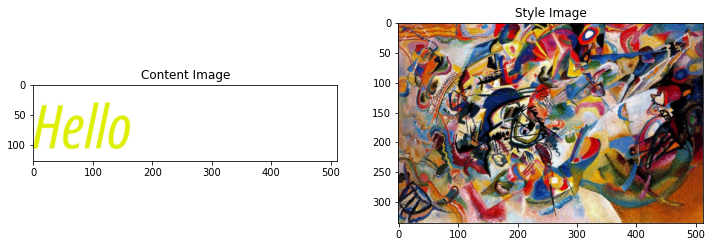

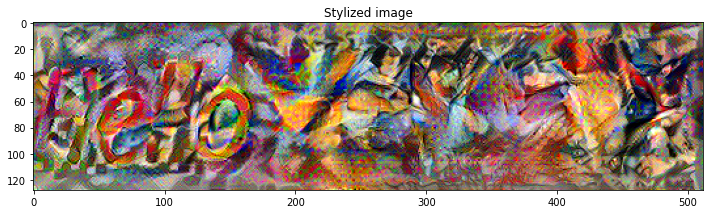

In [10]:
fontface = '/content/fonts/' + choice(os.listdir('/content/fonts/'))
print(fontface)
test_img_path = create_image_for_text('Hello', fontface)

img_encryptor = ImageEncryptor()
enc = img_encryptor.encrypt(test_img_path)
img_encryptor.decrypt(enc)
plt.imshow(Image.open(test_img_path))
s = StyleTransfer(test_img_path, style_path='style1.jpg')
s.stylize()
# img_encryptor = ImageEncryptor()
# enc = img_encryptor.encrypt(test_img_path)
# print(enc)
# os.system('rm '+test_img_path)

[('European_gallinule', 0.13859372), ('fountain', 0.07182328), ('lorikeet', 0.057070713), ('stole', 0.04036197), ('poncho', 0.03611863)]
block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



  0%|          | 1/1000 [00:00<02:03,  8.08it/s]

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.12680782
    max:  7503.2734
    mean:  852.7475

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  392958.9
    mean:  34852.516

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1662030.2
    mean:  42501.93

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  24759180.0
    mean:  516737.8

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  180080.36
    mean:  1643.0416

Contents:
   block5_conv2
    shape:  (1, 8, 32, 512)
    min:  0.0
    max:  1162.5052
    mean:  13.19247


100%|██████████| 1000/1000 [00:31<00:00, 31.88it/s]


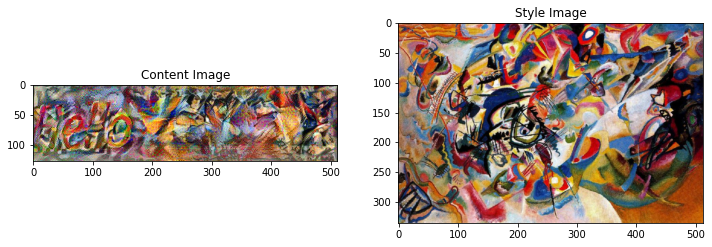

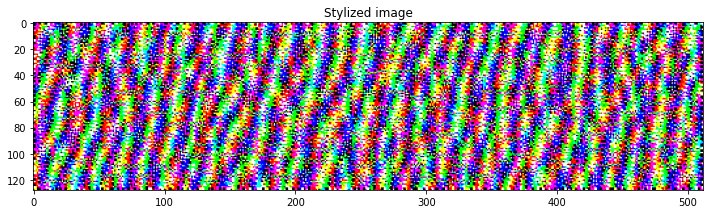

In [12]:
s = StyleTransfer('stylized.jpg', style_path='style1.jpg')
tf.config.run_functions_eagerly(True)
s.destylize()